LOGISTIC REGRESSION
Model Accuracy
*   Initial_Model: 0.9969615570919019  
*   Model_by_applying class_weight='balanced':  0.987714122154212
*   Model by applying smote_smpling: 0.9879638327853453
*   model with hold_out_test_set :  0.9968294974166275

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# **INITIAL MODEL FOR LOGISTIC REGESSION**

In [51]:
# === IMPORTS ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, roc_auc_score
)
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the dataset
url = "/content/drive/MyDrive/enhanced_featured_data.csv"
df = pd.read_csv(url)
# === DROP UNUSED COLUMNS ===
df.drop(['listingkey'], axis=1, inplace=True)

# === CONVERT DATE COLUMNS TO FEATURES ===
df['listingcreationdate'] = pd.to_datetime(df['listingcreationdate'], errors='coerce')
df['listing_year'] = df['listingcreationdate'].dt.year
df['listing_month'] = df['listingcreationdate'].dt.month
df['listing_dayofweek'] = df['listingcreationdate'].dt.dayofweek
df.drop(['listingcreationdate'], axis=1, inplace=True)

# === HANDLE MISSING VALUES ===
df = df.dropna()

# === DROP HIGH CARDINALITY CATEGORICAL COLUMNS ===
categorical_cols = df.select_dtypes(include='object').columns.tolist()
high_cardinality = [col for col in categorical_cols if df[col].nunique() > 50]
df.drop(columns=high_cardinality, inplace=True)

# === LABEL ENCODING FOR REMAINING CATEGORICAL COLUMNS ===
label_cols = df.select_dtypes(include='object').columns
for col in label_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# === SPLIT FEATURES AND TARGET ===
X = df.drop('loan_status_binary', axis=1)
y = df['loan_status_binary']

# === TRAIN TEST SPLIT ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === FEATURE SCALING ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === TRAIN MODEL ===
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# === PREDICT ===
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# === EVALUATE ===
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Additional Metrics
print("\nModel Performance Metrics:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba):.4f}")

# === OPTIONAL: Preview Prediction Probabilities ===
proba_df = pd.DataFrame(model.predict_proba(X_test), columns=['Prob_Class_0', 'Prob_Class_1'])
print("\n🔍 Sample Prediction Probabilities:\n", proba_df.head())


✅ Accuracy: 0.9969615570919019

📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19109
           1       1.00      0.98      0.99      3600

    accuracy                           1.00     22709
   macro avg       1.00      0.99      0.99     22709
weighted avg       1.00      1.00      1.00     22709


🧩 Confusion Matrix:
 [[19105     4]
 [   65  3535]]

Model Performance Metrics:
Accuracy:  0.9970
Precision: 0.9989
Recall:    0.9819
F1-Score:  0.9903
ROC-AUC:   0.9999

🔍 Sample Prediction Probabilities:
    Prob_Class_0  Prob_Class_1
0      0.995628      0.004372
1      0.995269      0.004731
2      0.999289      0.000711
3      0.999571      0.000429
4      0.999984      0.000016


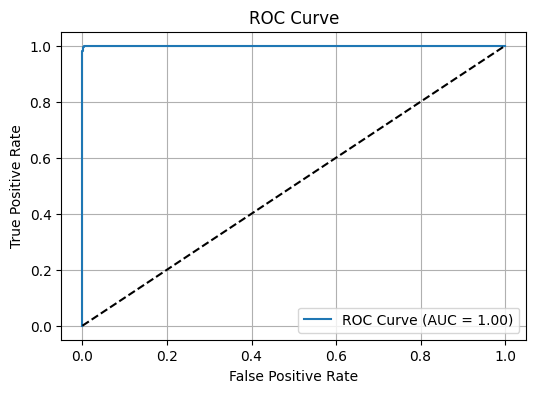

In [52]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# **K-Fold Cross validation**

In [53]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)
import numpy as np

# ===== Initialize StratifiedKFold ========
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = LogisticRegression(max_iter=1000, class_weight='balanced')

# ===== Store metrics =====
train_metrics, test_metrics = [], []

for train_idx, test_idx in skf.split(X, y):
    # ===== Correct indexing with .iloc ======
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


      # ===== Scale features within each fold ======
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ====== Train model =======
    model.fit(X_train_scaled, y_train)

    # ==== Training set predictions =====
    train_pred = model.predict(X_train_scaled)
    train_pred_proba = model.predict_proba(X_train_scaled)[:, 1]

    # ==== Test set predictions ====
    test_pred = model.predict(X_test_scaled)
    test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # ===== Store metrics ====
    train_metrics.append({
        'accuracy': accuracy_score(y_train, train_pred),
        'precision': precision_score(y_train, train_pred),
        'recall': recall_score(y_train, train_pred),
        'f1': f1_score(y_train, train_pred),
        'auc': roc_auc_score(y_train, train_pred_proba)
    })

    test_metrics.append({
        'accuracy': accuracy_score(y_test, test_pred),
        'precision': precision_score(y_test, test_pred),
        'recall': recall_score(y_test, test_pred),
        'f1': f1_score(y_test, test_pred),
        'auc': roc_auc_score(y_test, test_pred_proba),
        'cm': confusion_matrix(y_test, test_pred)
    })

# **Training vs testing Performance of Initial Model**

In [54]:
def print_metrics(metrics, name):
    print(f"\n{name} Metrics (Avg ± Std):")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
        values = [fold[metric] for fold in metrics]
        print(f"- {metric.capitalize()}: {np.mean(values):.4f} ± {np.std(values):.4f}")

print_metrics(train_metrics, "Training")
print_metrics(test_metrics, "Testing")



Training Metrics (Avg ± Std):
- Accuracy: 0.9984 ± 0.0001
- Precision: 0.9955 ± 0.0006
- Recall: 0.9942 ± 0.0007
- F1: 0.9949 ± 0.0002
- Auc: 0.9999 ± 0.0000

Testing Metrics (Avg ± Std):
- Accuracy: 0.9982 ± 0.0003
- Precision: 0.9952 ± 0.0007
- Recall: 0.9931 ± 0.0013
- F1: 0.9942 ± 0.0009
- Auc: 0.9999 ± 0.0001


In [55]:
avg_cm = np.mean([fold['cm'] for fold in test_metrics], axis=0)
print("\nAverage Confusion Matrix:")
print(avg_cm)



Average Confusion Matrix:
[[1.9104e+04 1.7200e+01]
 [2.4600e+01 3.5632e+03]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


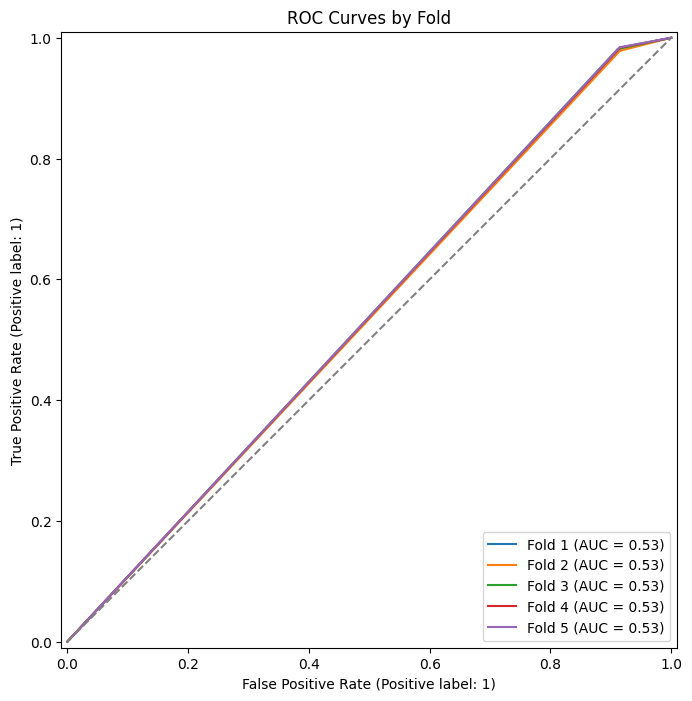

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(10, 8))
for i, (_, test_idx) in enumerate(skf.split(X, y)):
    RocCurveDisplay.from_predictions(
        y.iloc[test_idx],
        model.predict_proba(X.iloc[test_idx])[:, 1],
        name=f"Fold {i+1}",
        ax=plt.gca()
    )
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curves by Fold')
plt.show()



Training vs Testing Performance:
Accuracy Difference: 0.0002
AUC Difference: 0.0000


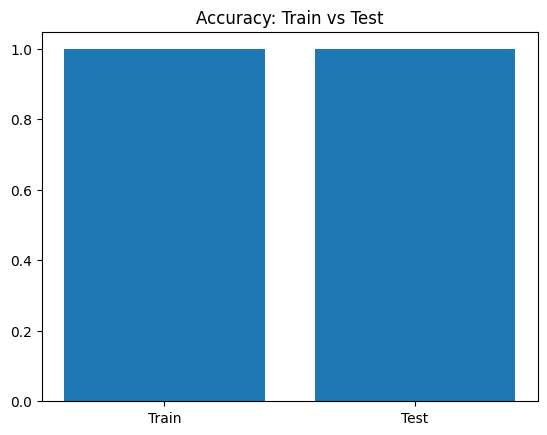

In [57]:
# ====== Compare training vs testing metrics ======
print("\nTraining vs Testing Performance:")
print(f"Accuracy Difference: {np.mean([t['accuracy'] for t in train_metrics]) - np.mean([t['accuracy'] for t in test_metrics]):.4f}")
print(f"AUC Difference: {np.mean([t['auc'] for t in train_metrics]) - np.mean([t['auc'] for t in test_metrics]):.4f}")

# ==== Visual comparison =====
plt.bar(['Train', 'Test'],
        [np.mean([t['accuracy'] for t in train_metrics]),
         np.mean([t['accuracy'] for t in test_metrics])])
plt.title('Accuracy: Train vs Test')
plt.show()


# **Class Imbalance Analysis**

Target variable distribution:
loan_status_binary
0    95606
1    17939
Name: count, dtype: int64

Target variable proportions:
loan_status_binary
0    84.200978
1    15.799022
Name: proportion, dtype: float64


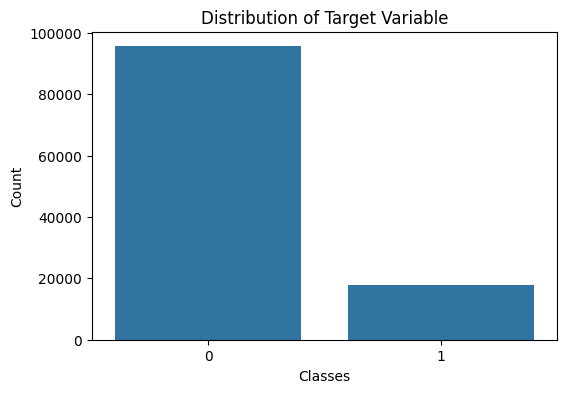


Potential class imbalance detected! Minority class is 15.80% of total.


In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Target variable distribution:")
print(y.value_counts())
print("\nTarget variable proportions:")
print(y.value_counts(normalize=True) * 100)

# ===== Visualize the distribution ====
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Distribution of Target Variable')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

#  ==== Define an imbalance threshold (e.g., if minority class is less than 20-30%) ====
imbalance_threshold = 0.20 # 20%
minority_class_proportion = y.value_counts(normalize=True).min()

if minority_class_proportion < imbalance_threshold:
    print(f"\nPotential class imbalance detected! Minority class is {minority_class_proportion:.2%} of total.")
else:
    print("\nClass distribution seems relatively balanced.")


# **LOGISTIC REGRESSION MODEL by applying class_weight='balanced'**

In [59]:
from sklearn.linear_model import LogisticRegression

# For Logistic Regression
# === TRAIN MODEL ===
log_reg_model_balanced = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
# Fit and evaluate as usual with your balanced model
log_reg_model_balanced.fit(X_train, y_train)

X_test = scaler.transform(X_test)

# === PREDICT ===
y_pred = log_reg_model_balanced.predict(X_test)
y_pred_proba = log_reg_model_balanced.predict_proba(X_test)[:, 1]

# === EVALUATE ===
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Additional Metrics
print("\nModel Performance Metrics:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba):.4f}")

# === Preview Prediction Probabilities ===
proba_df = pd.DataFrame(model.predict_proba(X_test), columns=['Prob_Class_0', 'Prob_Class_1'])
print("\n🔍 Sample Prediction Probabilities:\n", proba_df.head())


✅ Accuracy: 0.987714122154212

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     19121
           1       1.00      0.92      0.96      3588

    accuracy                           0.99     22709
   macro avg       0.99      0.96      0.98     22709
weighted avg       0.99      0.99      0.99     22709


🧩 Confusion Matrix:
 [[19121     0]
 [  279  3309]]

Model Performance Metrics:
Accuracy:  0.9877
Precision: 1.0000
Recall:    0.9222
F1-Score:  0.9595
ROC-AUC:   0.9964

🔍 Sample Prediction Probabilities:
    Prob_Class_0  Prob_Class_1
0      0.999291      0.000709
1      0.997680      0.002320
2      0.993449      0.006551
3      0.991131      0.008869
4      0.989199      0.010801

Models initialized with class weighting for imbalance handling.


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


# **LOGISTIC REGRESSION MODEL by applying SMOTE Sampling**

In [62]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split

# === 1ST SPLIT: TRAIN and TEST SETS ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_test = scaler.transform(X_test)

print(f"Original training set shape: {Counter(y_train)}")

# === APPLY SMOTE ===
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled training set shape: {Counter(y_train_resampled)}")


Original training set shape: Counter({0: 66924, 1: 12557})
Resampled training set shape: Counter({0: 66924, 1: 66924})


In [63]:
# === TRAIN MODEL ===
log_reg_model_smote = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model_smote.fit(X_train_resampled, y_train_resampled)

# === PREDICT ===
y_pred = log_reg_model_smote.predict(X_test)
y_pred_proba = log_reg_model_smote.predict_proba(X_test)[:, 1]

# === EVALUATE ===
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Additional Metrics
print("\nModel Performance Metrics:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba):.4f}")

# === OPTIONAL: Preview Prediction Probabilities ===
proba_df = pd.DataFrame(model.predict_proba(X_test), columns=['Prob_Class_0', 'Prob_Class_1'])
print("\n🔍 Sample Prediction Probabilities:\n", proba_df.head())


✅ Accuracy: 0.9879638327853453

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     28682
           1       1.00      0.92      0.96      5382

    accuracy                           0.99     34064
   macro avg       0.99      0.96      0.98     34064
weighted avg       0.99      0.99      0.99     34064


🧩 Confusion Matrix:
 [[28682     0]
 [  410  4972]]

Model Performance Metrics:
Accuracy:  0.9880
Precision: 1.0000
Recall:    0.9238
F1-Score:  0.9604
ROC-AUC:   0.9969

🔍 Sample Prediction Probabilities:
    Prob_Class_0  Prob_Class_1
0      0.999424      0.000576
1      0.990188      0.009812
2      0.979088      0.020912
3      0.975757      0.024243
4      0.999886      0.000114


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Assuming X (features) and y (target) are pandas DataFrame/Series

# 1ST SPLIT: 70% TRAIN, 30% TEMP (validation + test) ====
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# 2ND SPLIT: 50% VALIDATION, 50% TEST OF THE TEMP SET
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

scaler = StandardScaler()

# === SCALING ===
X_train_scaled = scaler.fit_transform(X_train)

# === TRANSFORMATION ===
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=1000, random_state=42)

# === TRAIN ===
log_reg.fit(X_train_scaled, y_train)

# === PREDICT ===
y_val_pred = log_reg.predict(X_val_scaled)

print("Logistic Regression Validation Metrics:")
print(classification_report(y_val, y_val_pred))

# === VALIDATE ===
y_test_pred = log_reg.predict(X_test_scaled)
print("Logistic Regression Test Metrics:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Accuracy:", accuracy_score(y_test, y_test_pred))




Logistic Regression Validation Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14341
           1       1.00      0.98      0.99      2691

    accuracy                           1.00     17032
   macro avg       1.00      0.99      0.99     17032
weighted avg       1.00      1.00      1.00     17032

Logistic Regression Test Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14341
           1       1.00      0.98      0.99      2691

    accuracy                           1.00     17032
   macro avg       1.00      0.99      0.99     17032
weighted avg       1.00      1.00      1.00     17032

Confusion Matrix:
 [[14333     8]
 [   46  2645]]
Accuracy: 0.9968294974166275
